# Comparison & Benchmarking
## Temporian vs. Pandas using variable-length moving windows

Data download and description: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states

In [1]:
import temporian as tp
import numpy as np
import pandas as pd

## Dataframe 1: onset/wakeup events

In [2]:
from pathlib import Path
data_dir = Path("~/Downloads") / "child-mind-institute-detect-sleep-states"

# Dataframe with events
df_ev = pd.read_csv(data_dir / "train_events.csv")[["series_id", "event", "timestamp"]]
df_ev

,series_id,event,timestamp
0,038441c925bb,onset,2018-08-14T22:26:00-0400
1,038441c925bb,wakeup,2018-08-15T06:41:00-0400
2,038441c925bb,onset,2018-08-15T19:37:00-0400
3,038441c925bb,wakeup,2018-08-16T05:41:00-0400
4,038441c925bb,onset,2018-08-16T23:03:00-0400
...,...,...,...
14503,fe90110788d2,wakeup,2017-09-06T04:07:00-0400
14504,fe90110788d2,onset,2017-09-06T23:35:00-0400
14505,fe90110788d2,wakeup,2017-09-07T09:17:00-0400
14506,fe90110788d2,onset,NaN


## Dataframe 2: accelerometer signals

In [3]:
# Dataframe with signals
df_sig = pd.read_parquet(data_dir / "train_series.parquet", columns=["series_id", "timestamp", "anglez"])

In [4]:
df_sig

,series_id,timestamp,anglez
0,038441c925bb,2018-08-14T15:30:00-0400,2.636700
1,038441c925bb,2018-08-14T15:30:05-0400,2.636800
2,038441c925bb,2018-08-14T15:30:10-0400,2.637000
3,038441c925bb,2018-08-14T15:30:15-0400,2.636800
4,038441c925bb,2018-08-14T15:30:20-0400,2.636800
...,...,...,...
127946335,fe90110788d2,2017-09-08T00:14:35-0400,-27.277500
127946336,fe90110788d2,2017-09-08T00:14:40-0400,-27.032499
127946337,fe90110788d2,2017-09-08T00:14:45-0400,-26.841200
127946338,fe90110788d2,2017-09-08T00:14:50-0400,-26.723900


## Filter and plot example data

In [5]:
# Filter data to use in the benchmarks
ids = df_ev["series_id"].unique()[:25]

df_events = df_ev[df_ev["series_id"].isin(ids) & df_ev["timestamp"].notnull()]
df_signals = df_sig[df_sig["series_id"].isin(ids) & df_sig["timestamp"].notnull()]

The number of plots (25) is larger than "options.max_num_plots=5". Only the first plots will be printed.


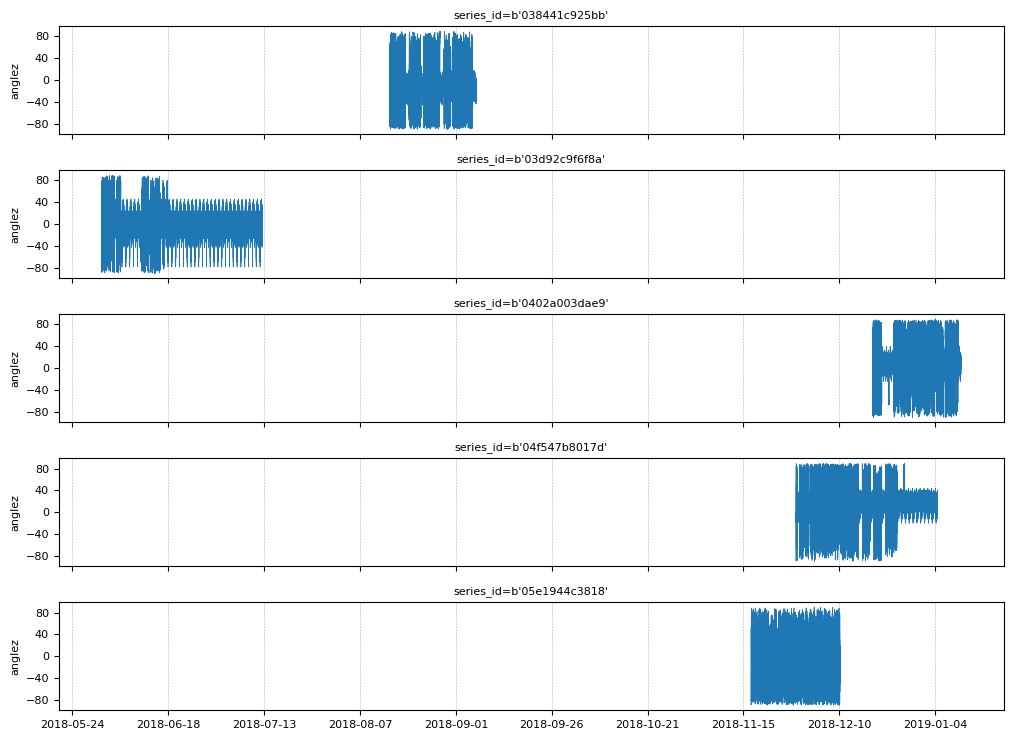

In [9]:
sig_evset = tp.from_pandas(df_signals[["series_id", "timestamp", "anglez"]], indexes=["series_id"])
sig_evset.plot(max_num_plots=5)

The number of plots (24) is larger than "options.max_num_plots=5". Only the first plots will be printed.


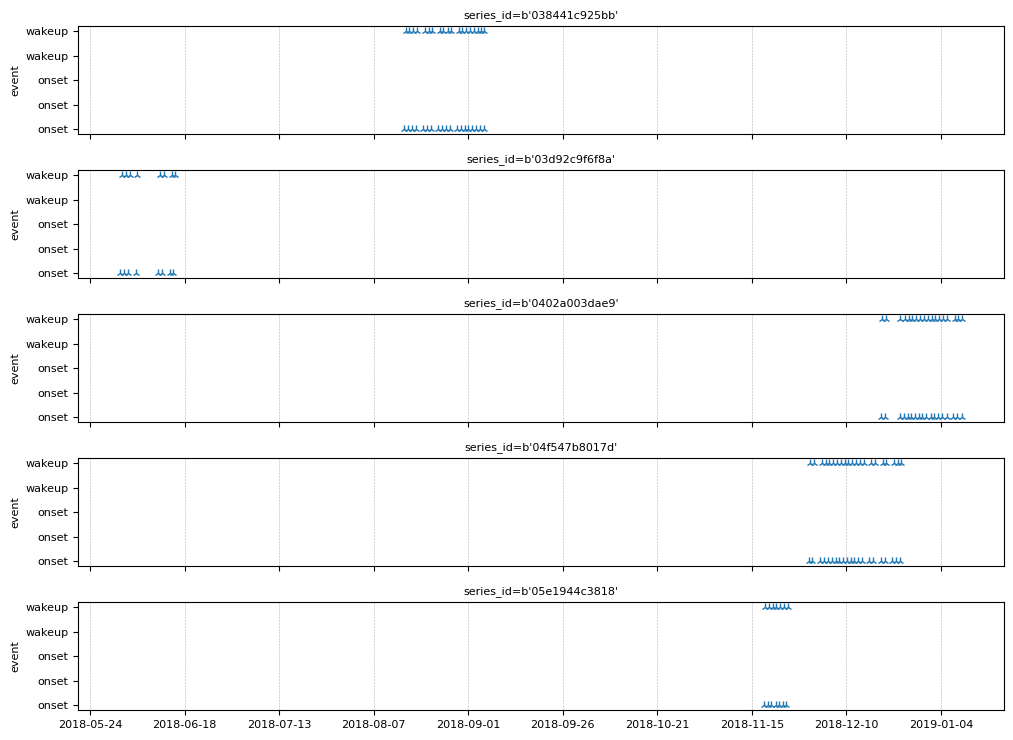

In [10]:
events_evset = tp.from_pandas(df_events[["series_id", "event", "timestamp"]], indexes=["series_id"])
events_evset.plot(max_num_plots=5)

## Temporian code

In [11]:
%%time

# Separate onset/wakeup events
onset = events_evset.filter(events_evset["event"].equal("onset"))
wakeup = events_evset.filter(events_evset["event"].equal("wakeup"))

# Step on each "wakeup" event, and get time since last "onset"
sleeping_windows = onset.since_last(sampling=wakeup)

# Calculate avg/std for each sleeping window
avg_per_sleep = sig_evset.simple_moving_average(window_length=sleeping_windows)
std_per_sleep = sig_evset.moving_standard_deviation(window_length=sleeping_windows)

# Put together avg/std
sleep_metrics = tp.glue(avg_per_sleep.prefix("avg_"), std_per_sleep.prefix("std_"))

CPU times: user 430 ms, sys: 3.86 ms, total: 433 ms
Wall time: 166 ms


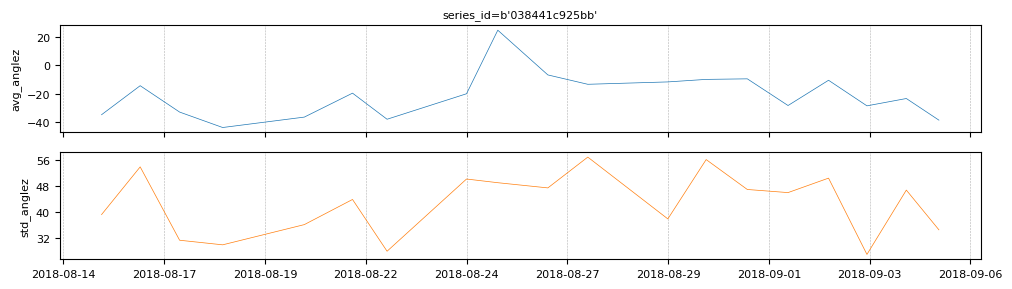

In [12]:
sleep_metrics.plot(indexes=["038441c925bb"], style='line')

### Pandas code

In [13]:
%%time

# Combine signals + events (onset/wakeup) and sort
df_combined = pd.concat([df_events, df_signals])
df_combined = df_combined.sort_values(by=["series_id", "timestamp"])

# Flag together all data points between onset/wakeup events
df_combined["event_id"] = df_combined["event"].notnull().cumsum()

# Remove even event_ids, to get only rows between 'onset' and 'wakeup'
df_nights = df_combined.loc[df_combined["event_id"] % 2 != 0]

# Remove onset/wakeup events, get only "anglez" rows
df_nights = df_nights[df_nights["anglez"].notnull()]

# Duplicate/rename anglez col and aggregate as average and std
df_nights = df_nights.assign(std_anglez=df_nights.anglez, avg_anglez=df_nights.anglez)
df_means = df_nights.groupby(["series_id", "event_id"]).aggregate({"avg_anglez": "mean", "std_anglez": "std", "timestamp": "max"})

# Remove hierarchical index after groupby
df_result = df_means.reset_index()

CPU times: user 14.6 s, sys: 1.1 s, total: 15.7 s
Wall time: 15.7 s


In [14]:
df_result

,series_id,event_id,avg_anglez,std_anglez,timestamp
0,038441c925bb,1,-34.890808,39.140336,2018-08-15T06:40:55-0400
1,038441c925bb,3,-14.400938,53.760804,2018-08-16T05:40:55-0400
2,038441c925bb,5,-33.005249,31.276375,2018-08-17T05:09:55-0400
3,038441c925bb,7,-43.934635,29.851742,2018-08-18T06:47:55-0400
4,038441c925bb,9,-36.568260,36.066789,2018-08-20T07:24:55-0400
...,...,...,...,...,...
440,137b99e936ab,853,-1.829077,41.476442,2018-08-08T22:32:55-0400
441,137b99e936ab,855,-17.296843,32.420218,2018-08-10T01:40:55-0400
442,137b99e936ab,857,-26.039988,30.684322,2018-08-11T03:47:55-0400
443,137b99e936ab,859,-17.782885,26.324084,2018-08-14T17:40:55-0400


## Analysis of results

Temporian code is shorter, very easy to understand, more robust and way faster for this use case.

With the first 10 indexes, the gain in speed in my local run is ~100x in this case (`5.89s/63.1ms = 93.3`).

Using the first 25 indexes, the relation is almost the same, the time for pandas is ~15 seconds which is significant.

This is important even for EDA purposes, since Temporian is almost instantaneous, being still comfortable to use with amounts of data where pandas is very slow and likely to run out of memory.

## Verification of results

<Axes: xlabel='timestamp'>

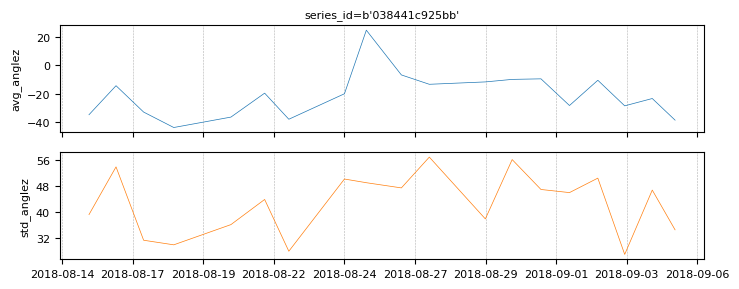

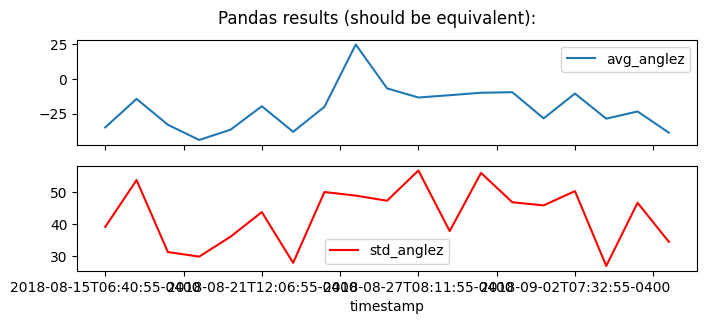

In [15]:
import matplotlib.pyplot as plt

# Select one series to plot
series_id = "038441c925bb"
# series_id = "0cd1e3d0ed95"


# Temporian plot
sleep_metrics.plot(indexes=[series_id], style='line', width_px=750)

# Pandas plot
df_series = df_result[df_result["series_id"] == series_id]
fig, axes = plt.subplots(nrows=2, figsize=(8, 3), sharex=True)
fig.suptitle("Pandas results (should be equivalent):")
df_series.plot(x="timestamp", y="avg_anglez", ax=axes[0])
df_series.plot(x="timestamp", y="std_anglez", c='r', ax=axes[1])
